<a href="https://colab.research.google.com/github/hyojunyee/kita_2404/blob/main/m9_VISION%20%EC%9D%91%EC%9A%A9/vision_02_CNN_%EB%AA%A8%EB%8D%B8%EA%B0%9C%EC%84%A0_0909.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 모델 개선
- 과대적합 방지 - 학습 파라미터 수 축소
- 모델 성능 높이기 - 레이어 추가
- 모델 성능 높이기 - 이미지 증식

- SpatialDropout2D: 2D 공간에서 특정 뉴런을 무작위로 드롭아웃 합니다.
- ReduceLROnPlateau: 학습 성능이 개선되지 않을 경우 학습률을 동적으로 감소시킵니다.
- ImageDataGenerator" 이미지 데이터를 실시간으로 증강(augmentation)시키는 클래스 입니다. 데이터 양을 늘리고 과적합을 방지하기 위해 이미지 회전, 확대, 축소 등의 변환을 수행할 수 있습니다.

In [1]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout, SpatialDropout2D, Reshape, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# 데이터 로드
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 이미지 데이터에 채널 차원이 명시적으로 없는 경우(예: (28,28) 크기의 이미지) 채널 차원을 추가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# 이미지 데이터 정규화 (픽셀 값을 0-1 범위로 변환)
x_train = x_train / 255.0
x_test = x_test / 255.0

# 데이터 셰이프 출력
print(x_train.shape)    # (60000, 28, 28, 1)
print(x_test.shape)     # (60000, )
print(y_train.shape)    # (10000, 28, 28, 1)
print(y_test.shape)     # (10000, )

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


In [3]:
class_names = ['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

In [4]:
# 모델 구성 및 컴파일
def build_model():
    # model=Sequential()
    input = Input(shape=(28,28,1))
    output = Conv2D(filters=32, kernel_size=(3, 3))(input)
    output = Conv2D(filters=64, kernel_size=(3, 3))(output)
    output = Conv2D(filters=64, kernel_size=(3, 3))(output)
    output = Flatten()(output)
    output = Dense(128, activation='relu')(output)
    output = Dense(64, activation='relu')(output)
    output = Dense(10, activation='softmax')(output)

    model = Model(inputs=input, outputs=output) # 모델이 하나 이상의 입력을 받을 수 있으며, 출력은 단일 출력을 함.

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',   # 클레스가 정수일 때 사용.
                  metrics=['accuracy']
                  )
    return model

model_1 = build_model()
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,029,706 (15.37 MB)

 Trainable params: 4,029,706 (15.37 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model.keras', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1,          # 로그를 출력
    save_best_only=True # 가장 좋은 성능을 가진 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10,        # 성능 개선이 없는 에폭을 몇번까지 허용 할지 설정
    verbose=1,          # 로그를 출력
)

# 학습실행
hist_1 = model_1.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping]    # 콜백 리스트에 추가
)

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7521 - loss: 0.6936
Epoch 1: val_loss improved from inf to 0.38976, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.7523 - loss: 0.6930 - val_accuracy: 0.8581 - val_loss: 0.3898
Epoch 2/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8745 - loss: 0.3454
Epoch 2: val_loss improved from 0.38976 to 0.37349, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8745 - loss: 0.3454 - val_accuracy: 0.8648 - val_loss: 0.3735
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8927 - loss: 0.2898
Epoch 3: val_loss improved from 0.37349 to 0.36087, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8927 - loss: 0.2898 - val_accuracy: 0.8734 - val_loss: 0.3609
Epoch 4/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9147 - loss: 0.2296
Epoch 4: val_loss did not improve from 0.36087

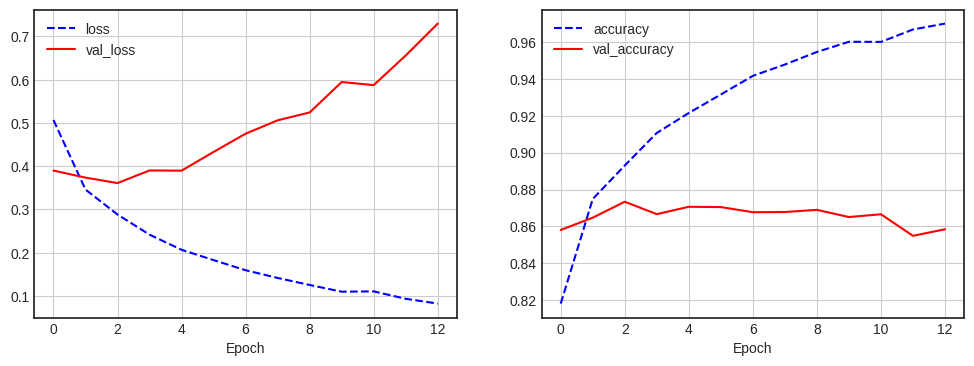

In [6]:
hist_1.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_1.history['loss'], 'b--', label='loss')
plt.plot(hist_1.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_1.history['accuracy'], 'b--', label='accuracy')
plt.plot(hist_1.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

In [7]:
model_1.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8581 - loss: 0.7493


[0.7651495337486267, 0.8547999858856201]

### 모델 구성 및 학습: 과대적합 방지

- 학습 파라미터의 수 비교
  - 모델 1은 더 많은 Conv2D 레이어를 포함하고 있으며, MaxPooling2D 및 Dropout 레이어가 없으므로 학습할 파라미터가 더 많습니다.
  - 모델 2는 Conv2D 레이어 후 MaxPooling2D와 Dropout 레이어를 추가하여 파라미터 수를 줄이는 동시에, 과적합을 방지하는 데 더 신경 쓴 모델입니다.

In [8]:
# 슬림한 모델로 바꾼 결과 과적합은 방지하지만 성능은 좋지 않음
def build_model2():
    input = Input(shape=(28,28,1))
    output = Conv2D(filters=32, kernel_size=(3, 3))(input)
    output = MaxPooling2D()(output)
    output = Conv2D(filters=64, kernel_size=(3, 3))(output)
    output = Dropout(0.4)(output)
    output = MaxPooling2D(strides=(2,2))(output)
    output = Conv2D(filters=64, kernel_size=(3, 3))(output)
    output = Dropout(0.4)(output)
    output = MaxPooling2D(strides=(2,2))(output)
    output = Flatten()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.4)(output)
    output = Dense(64, activation='relu')(output)
    output = Dropout(0.4)(output)
    output = Dense(10, activation='softmax')(output)

    model = Model(inputs=input, outputs=output) # 모델이 하나 이상의 입력을 받을 수 있으며, 출력은 단일 출력을 함.

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',   # 클레스가 정수일 때 사용.
                  metrics=['accuracy']
                  )
    return model

model_2 = build_model2()
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,970 (285.04 KB)

 Trainable params: 72,970 (285.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model2.keras', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1,          # 로그를 출력
    save_best_only=True # 가장 좋은 성능을 가진 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10,        # 성능 개선이 없는 에폭을 몇번까지 허용 할지 설정
    verbose=1,          # 로그를 출력
)

# 학습실행
hist_2 = model_2.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping]    # 콜백 리스트에 추가
)

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4474 - loss: 1.4528
Epoch 1: val_loss improved from inf to 0.66978, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.4478 - loss: 1.4516 - val_accuracy: 0.7601 - val_loss: 0.6698
Epoch 2/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7407 - loss: 0.7066
Epoch 2: val_loss improved from 0.66978 to 0.58683, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7408 - loss: 0.7064 - val_accuracy: 0.7941 - val_loss: 0.5868
Epoch 3/40
325/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7729 - loss: 0.6309
Epoch 3: val_loss improved from 0.58683 to 0.54131, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7729 - loss: 0.6306 - val_accuracy: 0.8046 - val_loss: 0.5413
Epoch 4/40
315/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7955 - loss: 0.5736
Epoch 4: val_loss improved from 0.54131 to 0.520

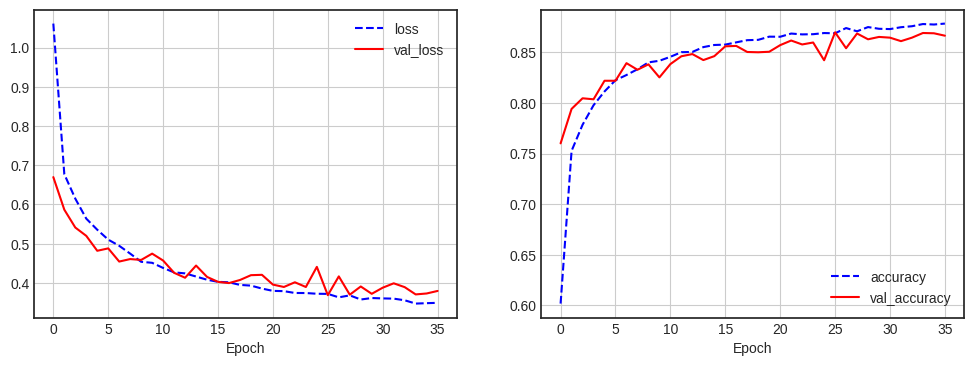

In [10]:
hist_2.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_2.history['loss'], 'b--', label='loss')
plt.plot(hist_2.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_2.history['accuracy'], 'b--', label='accuracy')
plt.plot(hist_2.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

In [22]:
model_2.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8571 - loss: 0.4017


[0.39912694692611694, 0.8586000204086304]

### 모델 성능 높이기: 레이어 추가

padding='same'과 'valid'옵션을 코드 내에서 별도로 설정하는 이유
- 모델 설계자가 네트워크의 각 계층에서 출력의 크기와 특성 추출 방식을 세밀하게 제어하고자 하는 것이다.
- 아래 경우에는 초기에는 공간 차원을 유지하면서 입력 데이터의 전반적인 특성을 포착하고 네트워크가 깊어질 수록 더 추상화된 특성을 추출하려는 목적으로 생각해 볼 수 있음.

In [18]:
def build_model3():
    # 단일 입력 레이어 설정
    input = Input(shape=(28, 28, 1))

    # 첫 번째 Conv 블록
    output = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(input)
    output = BatchNormalization()(output)
    output = Conv2D(filters=64, kernel_size=3, activation='relu', padding='valid')(output)
    output = Dropout(0.5)(output)
    output = MaxPooling2D(strides=(2, 2))(output)

    # 두 번째 Conv 블록
    output = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(output)
    output = BatchNormalization()(output)
    output = Conv2D(filters=128, kernel_size=3, activation='relu', padding='valid')(output)
    output = Dropout(0.5)(output)
    output = MaxPooling2D(strides=(2, 2))(output)

    # 세 번째 Conv 블록
    output = Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(output)
    output = BatchNormalization()(output)
    output = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid')(output)
    output = Dropout(0.5)(output)
    output = MaxPooling2D(strides=(2, 2))(output)

    # Dense 레이어
    output = Flatten()(output)
    output = Dense(512, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(256, activation='relu')(output)
    output = Dropout(0.5)(output)

    # 출력 레이어
    output = Dense(10, activation='softmax')(output)

    # 모델 정의
    model = Model(inputs=input, outputs=output)

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# 모델 생성 및 요약 출력
model_3 = build_model3()
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 13, 13, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 1,411,530 (5.38 MB)

 Trainable params: 1,410,634 (5.38 MB)

 Non-trainable params: 896 (3.50 KB)

In [19]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model3.keras', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1,          # 로그를 출력
    save_best_only=True # 가장 좋은 성능을 가진 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10,        # 성능 개선이 없는 에폭을 몇번까지 허용 할지 설정
    verbose=1,          # 로그를 출력
)

# 학습실행
hist_3 = model_3.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping]    # 콜백 리스트에 추가
)

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6085 - loss: 1.1423
Epoch 1: val_loss improved from inf to 2.25718, saving model to best_model3.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.6089 - loss: 1.1412 - val_accuracy: 0.1867 - val_loss: 2.2572
Epoch 2/40
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8264 - loss: 0.4914
Epoch 2: val_loss improved from 2.25718 to 1.07227, saving model to best_model3.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8265 - loss: 0.4911 - val_accuracy: 0.6323 - val_loss: 1.0723
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8698 - loss: 0.3808
Epoch 3: val_loss improved from 1.07227 to 0.57639, saving model to best_model3.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8698 - loss: 0.3808 - val_accuracy: 0.8342 - val_loss: 0.5764
Epoch 4/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8827 - loss: 0.3318
Epoch 4: val_loss did not improve from 0.5

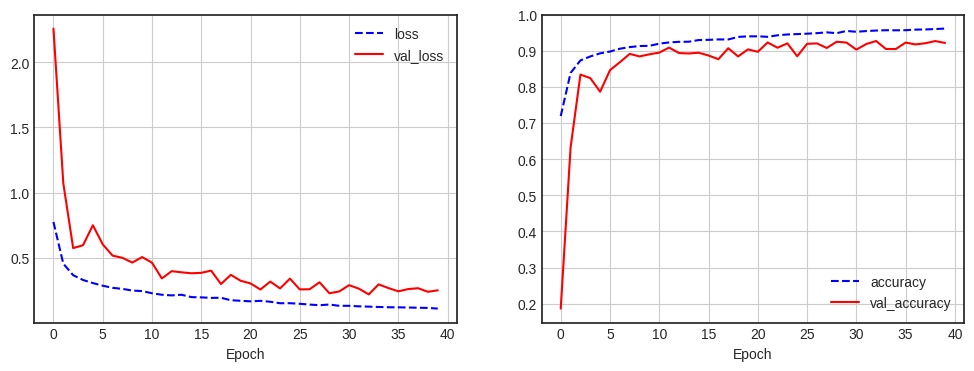

In [20]:
hist_3.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_3.history['loss'], 'b--', label='loss')
plt.plot(hist_3.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_3.history['accuracy'], 'b--', label='accuracy')
plt.plot(hist_3.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

In [23]:
model_3.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9156 - loss: 0.2685


[0.2545710802078247, 0.9194999933242798]

### CNN(Convolutional Neural Network)에서 파라미터 수의 증가 요소

- 필터(커널)의 수: CNN의 각 합성곱 계층(Convolutional layer)은 여러 필터(또는 커널)를 사용하여 입력 이미지에서 특징을 추출합니다. 필터의 수가 많아질수록 더 많은 특징을 동시에 학습할 수 있지만, 이는 동시에 해당 계층의 파라미터 수를 증가시킵니다.

- 필터의 크기: 필터의 크기가 클수록 한 번에 더 넓은 영역의 정보를 처리할 수 있습니다. 그러나 필터 크기의 증가는 필터 내의 가중치 수를 증가시켜, 결과적으로 해당 계층의 전체 파라미터 수를 증가시킵니다.

- 완전연결계층(Fully Connected layers)의 크기: CNN의 끝부분에서 주로 사용되는 전결합 계층은 모든 입력을 각 출력 뉴런에 연결합니다. 이 계층의 뉴런(유닛) 수가 많을수록 모델의 파라미터 수가 크게 증가합니다. 전결합 계층은 일반적으로 모델 내에서 가장 많은 파라미터를 가집니다.

- 계층의 깊이: CNN의 계층(레이어) 수가 많아질수록, 즉 모델이 더 깊어질수록, 모델이 더 복잡한 특징을 학습할 수 있게 되지만, 이는 또한 전체 파라미터 수를 증가시킵니다.

- 특성 맵(Feature Map)의 크기: 특정 합성곱 계층이 출력하는 특성 맵의 크기가 크면 클수록, 그 다음 계층(특히 전결합 계층이나 합성곱 계층)의 파라미터 수가 증가할 수 있습니다. 특성 맵의 크기는 입력 이미지의 크기와 필터의 크기, 스트라이드(stride), 패딩(padding)에 의해 결정됩니다.

이러한 요소들은 모두 모델의 학습 능력과 일반화 능력에 영향을 미칩니다. 파라미터 수가 많은 모델은 더 복잡한 특징을 학습할 수 있지만, 과적합(overfitting)의 위험도 높아질 수 있습니다. 반면, 파라미터 수가 적은 모델은 계산 효율성은 높지만, 모델의 표현 능력이 제한될 수 있습니다. 따라서 모델 설계 시 이러한 점을 고려하여 적절한 균형을 찾는 것이 중요합니다.

### 모델 성능 높이기: 이미지 증강(Image Augmentation)
데이터 증강은 기존의 훈련 데이터를 다양하게 변형하여 모델의 일반화 능력을 향상시키는 기법입니다. 각 파라미터는 특정 방식으로 이미지를 변형합니다.

ImageDataGenerator 파라미터 설명:
- rotation_range=10: 이미지를 -10도에서 10도 사이로 무작위로 회전합니다.
- zoom_range=0.2: 이미지를 80%에서 120% 사이로 무작위로 확대/축소합니다.
- shear_range=0.6: 이미지를 반시계 방향으로 0.6 라디안 내에서 기울입니다.
- width_shift_range=0.1와 height_shift_range=0.1: 각각 이미지를 수평과 수직으로 최대 10% 내에서 무작위로 이동합니다.
- horizontal_flip=True: 수평 방향으로 이미지를 무작위로 뒤집습니다. (예: 좌우 반전)
- vertical_flip=False: 수직 방향으로 이미지를 뒤집지 않습니다.

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 데이터 증강을 위한 설정
img_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

augment_size = 200      # 데이터 증강을 통해 생성하고자 하는 증강된 이미즤 수
print(x_train.shape)    # (60000, 28, 28, 1)
print(x_train.shape[0]) # 60000

(60000, 28, 28, 1)
60000


In [26]:
# flow 메소드는 실제로 이미지 데이터를 변환하는 작업을 수행
# np.tile(x_train[0].reshape(28*28*1),augment_size).reshape(-1,28,28,1)은 첫 번째 훈련 이미지(x_train[0])를 augment_size(200)만큼 복제하여 증강된 이미지 데이터의 형태로 변환.
# np.zeroxs(augment_size)는 증강된 이미지에 대한 레이블을 생성
# batch_size=augment_size는 한번에 생성할 증강된 이밎의 수를 지정
# next()[0]을 통해 생성된 이미지 배치 중 첫번째 배치(즉, 증강된 이미지들)에 접근
# 이미지 증강
x_augment_iterator = img_generator.flow(
    np.repeat(x_train[0].reshape(1, 28, 28, 1), augment_size, axis=0),  # 이미지 복제 후 증강
    np.zeros(augment_size),     # 라벨은 필요하지 않으므로 0으로 채움
    batch_size=augment_size,
    shuffle=False
)

# 첫번째 배치 가져오기
x_augment = next(x_augment_iterator)[0]

print(x_augment.shape)  # (200, 28, 28, 1)  # 증강된 이미지의 형상을 확인

(200, 28, 28, 1)


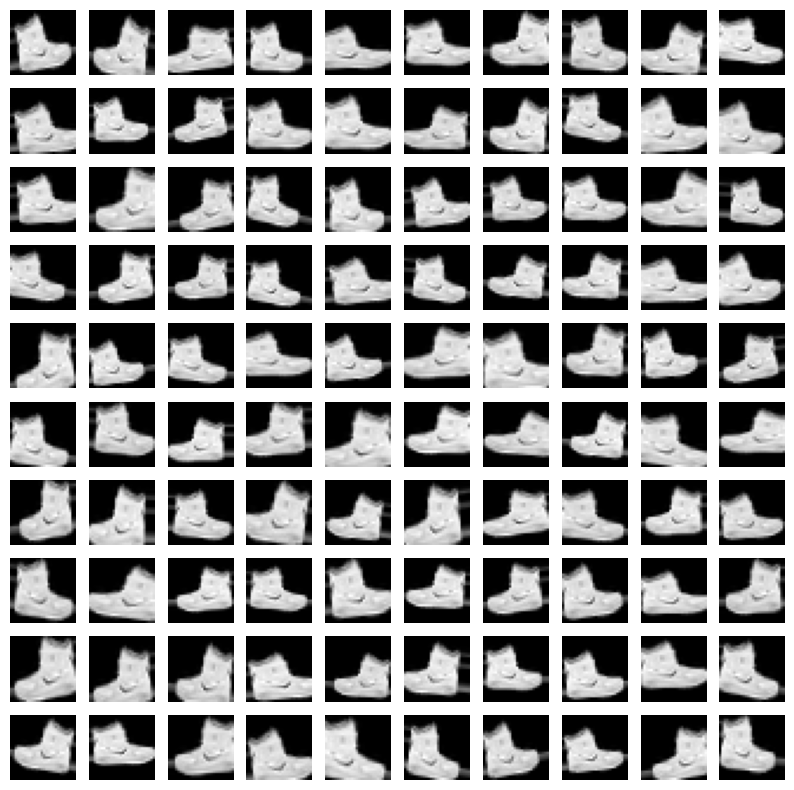

In [27]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(x_augment[i].reshape(28,28), cmap='gray')
# for i in range(1, 101):
#     plt.subplot(10,10,i)
#     plt.axis('off')
#     plt.imshow(x_augment[i-1].reshape(28,28), cmap='gray')

In [29]:
img_generator = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    shear_range=0.6,
    width_shift_range=0.15,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
augment_size = 30000
random_mask = np.random.randint(x_train.shape[0], size=augment_size)    # 증강할 이미지들의 인덱스 선정(무작위 30000개)
x_augmented = x_train[random_mask].copy()
y_augmented = y_train[random_mask].copy()

In [32]:
# 증강할 이미지 생성기 설정
x_augmented = img_generator.flow(
    x_augmented,                # 증강할 이미지
    np.zeros(augment_size),     # 증강된 이미지에 대한 레이블, 필요하지 않음으로 0으로 설정
    batch_size=augment_size,    # 한 번에 생성할 이미지의 수
    shuffle=False
)

# 첫번째 배치 가져오기
x_augmented = next(x_augmented)[0]

print(x_augmented.shape)  # (30000, 28, 28, 1)

(30000, 28, 28, 1)


In [34]:
# 기존 데이터에 증강시킨 데이터를 추가
x_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))
print(x_train.shape)
print(y_train.shape)

(90000, 28, 28, 1)
(90000,)


In [35]:
model_4 = build_model3()
model_4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 13, 13, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 1,411,530 (5.38 MB)

 Trainable params: 1,410,634 (5.38 MB)

 Non-trainable params: 896 (3.50 KB)

In [36]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model4.keras', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1,          # 로그를 출력
    save_best_only=True # 가장 좋은 성능을 가진 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10,        # 성능 개선이 없는 에폭을 몇번까지 허용 할지 설정
    verbose=1,          # 로그를 출력
)

# 학습실행
hist_4 = model_4.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping]    # 콜백 리스트에 추가
)

Epoch 1/40
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6481 - loss: 1.0176
Epoch 1: val_loss improved from inf to 2.70885, saving model to best_model4.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.6483 - loss: 1.0170 - val_accuracy: 0.1030 - val_loss: 2.7089
Epoch 2/40
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8447 - loss: 0.4424
Epoch 2: val_loss improved from 2.70885 to 1.49422, saving model to best_model4.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8448 - loss: 0.4424 - val_accuracy: 0.5036 - val_loss: 1.4942
Epoch 3/40
490/493 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8749 - loss: 0.3600
Epoch 3: val_loss improved from 1.49422 to 1.29740, saving model to best_model4.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8749 - loss: 0.3599 - val_accuracy: 0.5896 - val_loss: 1.2974
Epoch 4/40
491/493 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8868 - loss: 0.3233
Epoch 4: val_loss improved from 1.29740 t

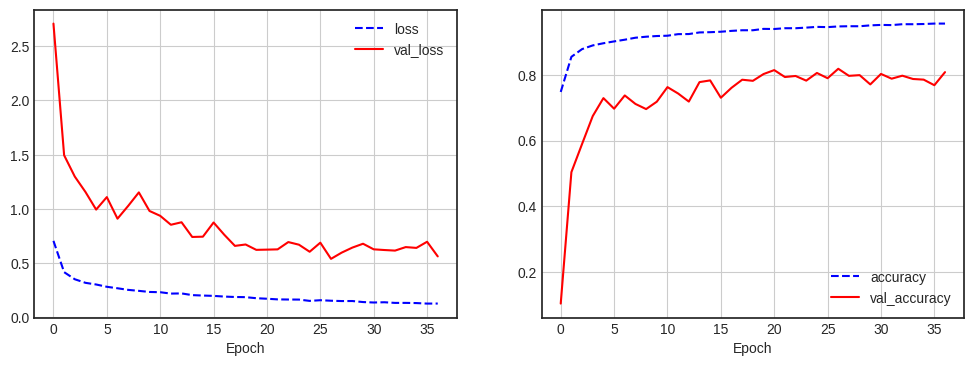

In [37]:
hist_4.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_4.history['loss'], 'b--', label='loss')
plt.plot(hist_4.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_4.history['accuracy'], 'b--', label='accuracy')
plt.plot(hist_4.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

In [38]:
model_4.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9147 - loss: 0.2622


[0.2560262084007263, 0.9150999784469604]